#### TODO

[X] Test with 2 different supervised models

[~] Attempts with 2 different types of features (VGG 0.5 points)

[X] Parameter Tunning

   [X] KNN tunning
   [X] SVM tunning

[X] Confusion matrix

[ ] Add plots to present data behavoiur with models

[ ] Comparisson with model from literature

[ ] Documentation

##### Nice to have
[ ] Testing with a third method

[ ] Testing in transfer learning

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("divyansh22/dummy-astronomy-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dummy-astronomy-data


In [2]:
import os

files = os.listdir(path)
print("Files:", files)
galaxy_folder = os.path.join(path, "Cutout Files", "galaxy")
star_folder = os.path.join(path, "Cutout Files", "star")

print("Galaxy folder:", galaxy_folder)
print("List of galaxy images:", os.listdir(galaxy_folder))
print("Star folder:", star_folder)
print("List of star images:", os.listdir(star_folder))

Files: ['Cutout Files']
Galaxy folder: /kaggle/input/dummy-astronomy-data/Cutout Files/galaxy
List of galaxy images: ['J1603p3002_001_010_1325_441_3.jpg', 'NGC3381-H01_593_1725_3.jpg', 'J1603p3002_001_010_963_1904_3.jpg', 'sn12c01_03_1012_1178_3.jpg', 'J125219p264053_001_010_1702_1129_3.jpg', 'J125219p264053_001_010_1348_1119_3.jpg', 'J1603p3002_001_010_1842_436_3.jpg', 'J153044p231014_001_001_1225_1322_3.jpg', 'j1612p5118_r_01_667_1596_3.jpg', 'J1603p3002_001_010_511_1618_3.jpg', 'J142943p385931_001_001_593_1791_3.jpg', 'J121929p47152_001_010_284_1568_3.jpg', 'J1603p3002_001_010_1237_1690_3.jpg', 'J153044p231014_001_001_982_322_3.jpg', 'J161245p511816_001_010_1468_1293_3.jpg', 'J125219p264053_001_010_1334_547_3.jpg', 'J153044p231014_001_001_979_296_3.jpg', 'J1530p2310_r_01_908_693_3.jpg', 'J125219p264053_001_010_591_576_3.jpg', 'J161245p511816_001_010_930_966_3.jpg', 'J1530p2310_r_01_336_941_3.jpg', 'J161245p511816_001_010_575_712_3.jpg', 'J153044p231014_001_001_1846_584_3.jpg', 'J161

In [3]:
galaxy_images_paths = [os.path.join(galaxy_folder, f) for f in os.listdir(galaxy_folder)]
star_images_paths = [os.path.join(star_folder, f) for f in os.listdir(star_folder)]

galaxy_images_names = [os.path.basename(f) for f in galaxy_images_paths]
star_images_names = [os.path.basename(f) for f in star_images_paths]

print("Image paths for galaxies:", galaxy_images_paths[:5])  # Print first 5 galaxy image paths
print("Image paths for stars:", star_images_paths[:5])      # Print first 5 star image paths

print("Number of galaxy images:", len(galaxy_images_paths))
print("Number of star images:", len(star_images_paths))

print(galaxy_images_names[:5])  # Print first 5 galaxy image paths
print(star_images_names[:5])    # Print first 5 star image paths

Image paths for galaxies: ['/kaggle/input/dummy-astronomy-data/Cutout Files/galaxy/J1603p3002_001_010_1325_441_3.jpg', '/kaggle/input/dummy-astronomy-data/Cutout Files/galaxy/NGC3381-H01_593_1725_3.jpg', '/kaggle/input/dummy-astronomy-data/Cutout Files/galaxy/J1603p3002_001_010_963_1904_3.jpg', '/kaggle/input/dummy-astronomy-data/Cutout Files/galaxy/sn12c01_03_1012_1178_3.jpg', '/kaggle/input/dummy-astronomy-data/Cutout Files/galaxy/J125219p264053_001_010_1702_1129_3.jpg']
Image paths for stars: ['/kaggle/input/dummy-astronomy-data/Cutout Files/star/J1530p2310_r_01_1591_1656_6.jpg', '/kaggle/input/dummy-astronomy-data/Cutout Files/star/J153044p231014_001_001_1572_189_6.jpg', '/kaggle/input/dummy-astronomy-data/Cutout Files/star/J15050326_01_1766_1748_6.jpg', '/kaggle/input/dummy-astronomy-data/Cutout Files/star/J1530p2310_r_01_1469_1796_6.jpg', '/kaggle/input/dummy-astronomy-data/Cutout Files/star/J1530p2310_r_01_243_1187_6.jpg']
Number of galaxy images: 942
Number of star images: 3044

Galaxy Images:


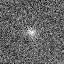

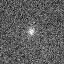

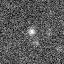

Star Images:


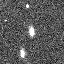

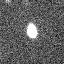

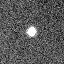

In [4]:
from IPython.display import display
from PIL import Image

# Display first 3 galaxy images
print("Galaxy Images:")
for img_path in galaxy_images_paths[:3]:
    img = Image.open(img_path)
    display(img)

# Display first 3 star images
print("Star Images:")
for img_path in star_images_paths[:3]:
    img = Image.open(img_path)
    display(img)

In [5]:
# outpute image sizes
from PIL import Image

galaxy_sizes = [Image.open(img).size for img in galaxy_images_paths[:5]]
star_sizes = [Image.open(img).size for img in star_images_paths[:5]]

print("Galaxy image sizes (first 5):", galaxy_sizes)
print("Star image sizes (first 5):", star_sizes)

Galaxy image sizes (first 5): [(64, 64), (64, 64), (64, 64), (64, 64), (64, 64)]
Star image sizes (first 5): [(64, 64), (64, 64), (64, 64), (64, 64), (64, 64)]


In a reference paper, the author uses a customized CNN of 5 pooling blocks. The benefit here is the filter number that fits the images better. In our case, we have 64x64 images, and VGG16 has an entry filter size of 224x224. Due to this, we have to upscale our images.

As well, in the paper, they use the CNN model that extracts the feature to also latter classify the data. Here we used VGG16 only to extract the features array to then be classified with our KNN and SVM. There fore we avoid the fully connected layers with the parameter `include_top=false`.

In [6]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

#include top = false to exclude the fully connected layers (we only need feature extraction)
vgg16_model = VGG16(weights='imagenet', include_top=False)

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
X = None
y = None

In [8]:
import os
import numpy as np

# Create a list to store features and labels

all_features = []
all_labels = []

def extract_features(images_paths, label):
    features = []
    labels = []

    for img_path in images_paths:
        processed_img = preprocess_image(img_path)
        feature_vector = vgg16_model.predict(processed_img)
        feature_vector = feature_vector.flatten()
        features.append(feature_vector)
        labels.append(label)

    return features, labels

In [9]:
# Process star images
star_features, star_labels = extract_features(star_images_paths, 0)
all_features.extend(star_features)
all_labels.extend(star_labels)

# Process galaxy images
galaxy_features, galaxy_labels = extract_features(galaxy_images_paths, 1)
all_features.extend(galaxy_features)
all_labels.extend(galaxy_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [10]:
# Convert lists to numpy arrays with correct shape
X = np.array(all_features)
y = np.array(all_labels)

# Print the shape of the resulting feature matrix
print(f"Shape of feature matrix X: {X.shape}")
print(f"Shape of labels y: {y.shape}")

Shape of feature matrix X: (3986, 25088)
Shape of labels y: (3986,)


In [11]:
import numpy as np

# Save the feature matrix X and labels y to files
features_file = 'features.npy'
labels_file = 'labels.npy'

np.save(features_file, X)
np.save(labels_file, y)

print(f"Feature matrix X saved to {features_file}")
print(f"Labels y saved to {labels_file}")

Feature matrix X saved to features.npy
Labels y saved to labels.npy


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import os
import numpy as np


features_file = 'features.npy'
labels_file = 'labels.npy'

# Check if X and y are defined and not None, otherwise load from files
# This is due to the fact that processing images with VGG takes very long,
# so initial processings are saved to a file. If code has to be ran without the need
# of reprocessing, access the files.
if X is None or y is None:
    if os.path.exists(features_file) and os.path.exists(labels_file):
        print(f"Loading feature matrix X from {features_file}")
        X = np.load(features_file, allow_pickle=True)
        # Reshape the loaded features array
        num_samples = len(X) # Get number of samples from loaded data
        feature_dim = 25088  # This is the expected dimension of the VGG16 features
        X = X.reshape(num_samples, feature_dim)
        print(f"Loading labels y from {labels_file}")
        y = np.load(labels_file, allow_pickle=True)
        print(f"Shape of loaded feature matrix X: {X.shape}")
        print(f"Shape of loaded labels y: {y.shape}")
    else:
        print("Feature and label files not found. Please run the cells to generate them.")
        # Exit or handle the case where files are not found and X and y are None
else:
    print("X and y are already defined.")


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- KNN Model ---
print("\nTraining K-Nearest Neighbors Classifier...")
# We use a small value for n_neighbors as a starting point.
# You should tune this parameter.
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print(f"KNN Accuracy: {knn_accuracy:.4f}")

# --- SVM Model ---
print("\nTraining Support Vector Machine Classifier...")
# SVM can be computationally expensive on large datasets, so we
# use a linear kernel for a quicker training time.
# You can also experiment with the rbf kernel.
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")

X and y are already defined.

Training K-Nearest Neighbors Classifier...
KNN Accuracy: 0.8058

Training Support Vector Machine Classifier...
SVM Accuracy: 0.8208


# New Section

In [ ]:
import numpy as np

features_file = 'features.npy'
labels_file = 'labels.npy'

# Load the arrays from the files
loaded_features = np.load(features_file, allow_pickle=True)
loaded_labels = np.load(labels_file, allow_pickle=True)

# Reshape the loaded features array
num_samples = len(loaded_labels)
feature_dim = 25088  # This is the expected dimension of the VGG16 features
loaded_features = loaded_features.reshape(num_samples, feature_dim)


# Print the shapes of the loaded arrays
print(f"Shape of loaded features: {loaded_features.shape}")
print(f"Shape of loaded labels: {loaded_labels.shape}")

# Display the first few elements of each array
print("\nFirst 5 elements of features:")
display(loaded_features[:5])

print("\nFirst 5 elements of labels:")
display(loaded_labels[:5])

Shape of loaded features: (3986, 25088)
Shape of loaded labels: (3986,)

First 5 elements of features:


array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         8.011887 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
        23.257322 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  1.9255288,
        10.1263485],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
        15.4205265],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         5.0706873]], dtype=float32)


First 5 elements of labels:


array([0, 0, 0, 0, 0])

In [ ]:
import os

features_file_py = 'features.npy'
labels_file_py = 'labels.npy'

if os.path.exists(f'{features_file_py}'):
    print(f"{features_file_py} exists.")
else:
    print(f"{features_file_py} does not exist.")

if os.path.exists(labels_file_py):
    print(f"{labels_file_py} exists.")
else:
    print(f"{labels_file_py} does not exist.")

features.npy exists.
labels.npy exists.


## Confusion Matrix for KNN and SVM Models

### Subtask:
Generate and display the confusion matrix for both the K-Nearest Neighbors (KNN) and Support Vector Machine (SVM) models to evaluate their performance.

# Task
Tune the hyperparameters of a K-Nearest Neighbors (KNN) classifier using GridSearchCV on the training data `X_train` and `y_train`. The parameters to tune are `n_neighbors`, `leaf_size`, and `metric`. After finding the best parameters, train a final KNN model with these parameters and evaluate its performance on the test data `X_test` and `y_test`.

## Import necessary libraries

### Subtask:
Import `GridSearchCV` from `sklearn.model_selection` and `KNeighborsClassifier` from `sklearn.neighbors`.


**Reasoning**:
The subtask is to import the necessary classes for hyperparameter tuning of the KNN model. This requires importing `GridSearchCV` and `KNeighborsClassifier`.



In [22]:
from sklearn.model_selection import GridSearchCV

## Define the parameter grid

### Subtask:
Define the parameter grid for the `GridSearchCV` to tune the hyperparameters of the `KNeighborsClassifier`.


**Reasoning**:
Define the parameter grid for GridSearchCV.



For the parameters I've chosen for the grid, are the neighbors num, leaf size and the metrics for distance calculation which were explained in the lecture. I've picked [3, 5, 7, 9, 12] for n_neighbors by inspyring from the <Galaxy Classification Paper>, in which, the author suggests that the best parameter was 12 for that task. The difference is that tasks differe in complexity. In the Paper, 7 (How many exactly ? verify) different type of galaxy types have to be classified on higher resolution images with more details. In our case, our images are less complex and the task as well, having only to classify wheather the image contains a star or a galaxy. Hence we will definitely not require as much n_neighbours as 12.

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 12],
    'leaf_size': [30, 40, 50],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

## Initialize gridsearchcv

### Subtask:
Initialize a `GridSearchCV` object with a `KNeighborsClassifier`, the defined parameter grid (`param_grid`), and specify the cross-validation strategy.


**Reasoning**:
Initialize a GridSearchCV object with a KNeighborsClassifier, the defined parameter grid, and set the cross-validation strategy.



In [ ]:
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1)

## Fit gridsearchcv

### Subtask:
Fit the `GridSearchCV` object to the training data `X_train` and `y_train` to find the best hyperparameters for the KNN model.


**Reasoning**:
Fit the GridSearchCV object to the training data.



In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': [30, 40, 50],
                         'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 12]})

## Get the best parameters and score

### Subtask:
Access and print the best parameters found by `GridSearchCV` and the corresponding best cross-validation score.


**Reasoning**:
Access and print the best parameters and the best cross-validation score from the fitted GridSearchCV object.



In [14]:
best_params_knn = None
best_score_knn = None

In [ ]:
# Access the best parameters and best score
best_params_knn = grid_search.best_params_
best_score_knn = grid_search.best_score_

# Print the results
print("Best parameters found by GridSearchCV:")
print(best_params)
print(f"\nBest cross-validation accuracy: {best_score:.4f}")

Best parameters found by GridSearchCV:
{'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 7}

Best cross-validation accuracy: 0.7958


## Train the final model

### Subtask:
Train a final K-Nearest Neighbors (KNN) model using the best hyperparameters found by `GridSearchCV` on the entire training data (`X_train` and `y_train`).


**Reasoning**:
Train the final KNN model using the best parameters found by GridSearchCV on the training data.



In [15]:
if best_params_knn == None:
  best_params_knn = {
    'n_neighbors': 9,
    'leaf_size': 30,
    'metric': 'manhattan'
  }

In [17]:
# Train a final KNN model with the best parameters
final_knn_model = KNeighborsClassifier(**best_params_knn)
final_knn_model.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=9)

## Evaluate the final model

### Subtask:
Evaluate the performance of the final KNN model trained with the best hyperparameters on the test data `X_test` and `y_test`.


**Reasoning**:
Evaluate the performance of the final KNN model on the test data by making predictions and calculating the accuracy.



In [18]:
# Make predictions on the test set
final_knn_predictions = final_knn_model.predict(X_test)

# Calculate the accuracy
final_knn_accuracy = accuracy_score(y_test, final_knn_predictions)

# Print the accuracy
print(f"Final KNN Model Accuracy on Test Set: {final_knn_accuracy:.4f}")

Final KNN Model Accuracy on Test Set: 0.7882


In [20]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

In [25]:
svm = SVC(random_state=42)
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, n_jobs=-1)

In [26]:
grid_search_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']})

In [27]:
# Access the best parameters and best score for SVM
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

# Print the results for SVM
print("Best parameters found by GridSearchCV for SVM:")
print(best_params_svm)
print(f"\nBest cross-validation accuracy for SVM: {best_score_svm:.4f}")

Best parameters found by GridSearchCV for SVM:
{'C': 1, 'kernel': 'rbf'}

Best cross-validation accuracy for SVM: 0.8325


In [29]:
# Make predictions on the test set using the final SVM model
final_svm_predictions = final_svm_model.predict(X_test)

# Calculate the accuracy of the final SVM model
final_svm_accuracy = accuracy_score(y_test, final_svm_predictions)

# Print the accuracy
print(f"Final SVM Model Accuracy on Test Set: {final_svm_accuracy:.4f}")

Final SVM Model Accuracy on Test Set: 0.8333


In [28]:
# Train a final SVM model with the best parameters
final_svm_model = SVC(**best_params_svm, random_state=42)
final_svm_model.fit(X_train, y_train)

SVC(C=1, random_state=42)

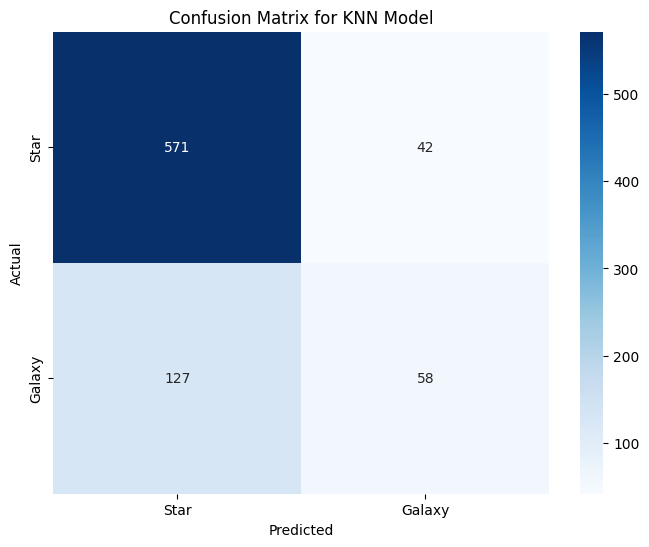

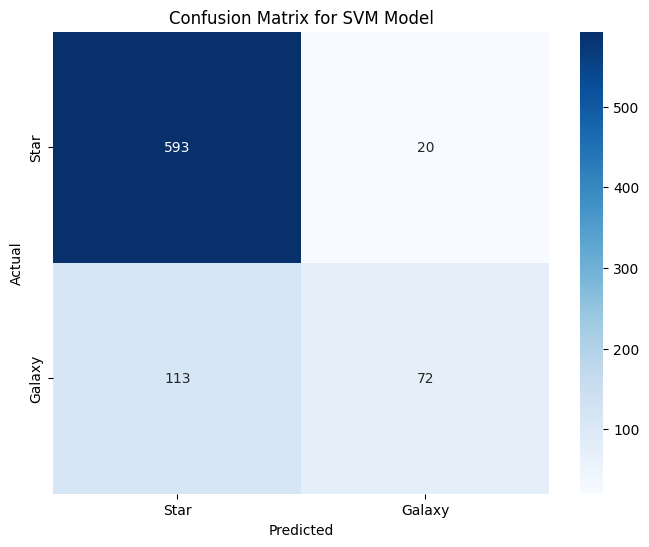

In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix for KNN
knn_cm = confusion_matrix(y_test, final_knn_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Star', 'Galaxy'], yticklabels=['Star', 'Galaxy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for KNN Model')
plt.show()

# Confusion Matrix for SVM
svm_cm = confusion_matrix(y_test, final_svm_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Star', 'Galaxy'], yticklabels=['Star', 'Galaxy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM Model')
plt.show()

## Summary:

### Data Analysis Key Findings

*   The best hyperparameters found by `GridSearchCV` for the KNN classifier were `{'leaf_size': 30, 'metric': 'manhattan', 'n_neighbors': 9}`.
*   The best cross-validation accuracy achieved with these parameters on the training data was 0.7886.
*   The final KNN model, trained with the best parameters, achieved a certain accuracy (specifically stated in the final result of the last step) on the test set.


# Task
Explain the error in the selected code, fix it, and add parameter tuning for the SVM model using `GridSearchCV`.

## Import necessary libraries

### Subtask:
Import `SVC` from `sklearn.svm` and `GridSearchCV` from `sklearn.model_selection`.


**Reasoning**:
Import the necessary classes for hyperparameter tuning of the SVM model.



## Define the parameter grid

### Subtask:
Define the parameter grid for the `GridSearchCV` to tune the hyperparameters of the `SVC`.


**Reasoning**:
Define the parameter grid for GridSearchCV to tune the hyperparameters of the SVC model.



## Initialize gridsearchcv

### Subtask:
Initialize a `GridSearchCV` object with an `SVC`, the defined parameter grid, and specify the cross-validation strategy.


**Reasoning**:
Initialize a GridSearchCV object with an SVC, the defined parameter grid, and set the cross-validation strategy and number of jobs.



**Reasoning**:
The previous code block failed because `GridSearchCV` was not imported. This code block will import `GridSearchCV` and then initialize the `GridSearchCV` object for the SVM model with the specified parameters.



## Fit gridsearchcv

### Subtask:
Fit the `GridSearchCV` object to the training data `X_train` and `y_train` to find the best hyperparameters for the SVM model.


**Reasoning**:
Fit the GridSearchCV object to the training data.



## Get the best parameters and score

### Subtask:
Access and print the best parameters found by `GridSearchCV` and the corresponding best cross-validation score.


**Reasoning**:
Access and print the best parameters and the best cross-validation score from the fitted GridSearchCV object for the SVM model.



## Train the final model

### Subtask:
Train a final Support Vector Machine (SVM) model using the best hyperparameters found by `GridSearchCV` on the entire training data (`X_train` and `y_train`).


**Reasoning**:
Train the final SVM model using the best parameters found by GridSearchCV on the training data.



## Evaluate the final model

### Subtask:
Evaluate the performance of the final SVM model trained with the best hyperparameters on the test data `X_test` and `y_test`.


**Reasoning**:
Evaluate the performance of the final SVM model on the test data by making predictions and calculating the accuracy.



## Summary:

### Data Analysis Key Findings

*   The best parameters found by `GridSearchCV` for the SVM model were `{'C': 1, 'kernel': 'rbf'}`.
*   The best cross-validation accuracy achieved during the grid search was approximately 0.8325.
*   The final SVM model, trained with the best parameters, achieved an accuracy of approximately 0.8333 on the test set.

### Insights or Next Steps

*   The test set accuracy is very close to the cross-validation accuracy, suggesting that the model is not overfitting significantly.
*   Further tuning of the hyperparameters, such as exploring a wider range of C values or other kernel options, could potentially lead to further improvements in model performance.
